In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
splitter = StratifiedKFold(n_splits=5)

In [3]:
data = pd.read_csv("../data/dataset.csv")
data.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [4]:
X = data["MESSAGE"]
y = data["CATEGORY"]
(X, y)

(0       Dear Homeowner,\n\n \n\nInterest Rates are at ...
 1       ATTENTION: This is a MUST for ALL Computer Use...
 2       This is a multi-part message in MIME format.\n...
 3       IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
 4       This is the bottom line.  If you can GIVE AWAY...
                               ...                        
 5791    I'm one of the 30,000 but it's not working ver...
 5792    Damien Morton quoted:\n\n>W3C approves HTML 4 ...
 5793    On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...
 5794    Once upon a time, Manfred wrote :\n\n\n\n> I w...
 5795    If you run Pick, and then use the "New FTOC" b...
 Name: MESSAGE, Length: 5796, dtype: object,
 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 5791    0
 5792    0
 5793    0
 5794    0
 5795    0
 Name: CATEGORY, Length: 5796, dtype: int64)

In [5]:
X_train_splits = []
X_test_splits = []
y_train_splits = []
y_test_splits = []

for train_index, test_index in splitter.split(X, y):
    print(len(train_index), len(test_index))
    X_train_splits.append(X[train_index].values)
    X_test_splits.append(X[test_index].values)
    y_train_splits.append(y[train_index].values)
    y_test_splits.append(y[test_index].values)

4636 1160
4637 1159
4637 1159
4637 1159
4637 1159


# Baseline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
mnb_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("model", MultinomialNB())
    ]
)

In [9]:
mnb_model.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', MultinomialNB())])

In [10]:
np.exp(mnb_model["model"].feature_log_prob_)[0]

array([3.65247525e-04, 7.28562411e-05, 3.20747211e-05, ...,
       7.35732970e-06, 7.35732970e-06, 7.35732970e-06])

In [11]:
count_vectorizer = CountVectorizer()
word_counts = count_vectorizer.fit_transform(X).todense() 

In [12]:
word_counts[0][word_counts[0] > 0]

matrix([[1, 2, 2, 2, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3]])

In [13]:
str(count_vectorizer.vocabulary_)[:200]

"{'dear': 32783, 'homeowner': 48159, 'interest': 52485, 'rates': 76551, 'are': 20099, 'at': 20632, 'their': 87457, 'lowest': 59509, 'point': 72497, 'in': 51557, '40': 7824, 'years': 98808, 'we': 95200,"

In [14]:
from wordcloud import WordCloud

In [15]:
features = TfidfVectorizer().fit_transform(X).todense()

In [16]:
!pip install wordcloud==1.9.3

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [17]:
import re

corpus = "\n".join(X)   
preprocessed_corpus = re.sub('\W+', '', corpus)

In [18]:
wc = WordCloud(font_path="./arial.ttf")
wc.generate("Hello world")

In [64]:
features[0]

(1, 103002)

In [35]:
cross_val_score(mnb_model, X, y, cv=10)

array([0.87413793, 0.90517241, 0.9       , 0.90517241, 0.89655172,
       0.90344828, 0.91364421, 0.88255613, 0.89982729, 0.89982729])

In [46]:
avg_scores = []
avg_cv_values = []
scores = []
cv_values = []
for cv in tqdm(range(2, 12)):
    cv_result = cross_val_score(mnb_model, X, y, cv=cv)
    avg_scores.append(np.mean(cv_result))
    scores.extend(cv_result)
    avg_cv_values.append(cv)
    cv_values.extend([cv] * len(cv_result)) 

100%|█| 10/10 [00:53<00:00,  5.30s


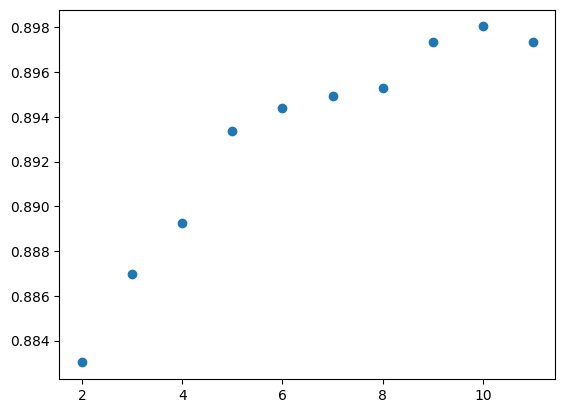

In [49]:
plt.scatter(y=avg_scores, x=avg_cv_values)
plt.show()

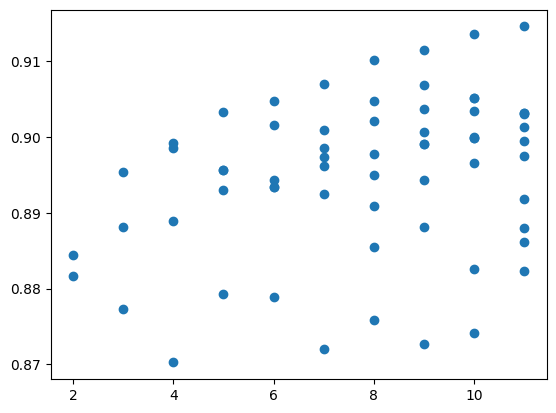

In [50]:
plt.scatter(y=scores, x=cv_values)
plt.show()

In [45]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [46]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.7 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.7 MB/s eta 0:00:002.9 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [47]:
from gensim.parsing.preprocessing import remove_stopwords

In [53]:
import re
from cleantext import clean
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def preprocess_text(text: str):
   # text = text.lower()
   # text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'<[^>]+>', "", text)
    text = remove_stopwords(text)
    text = re.sub(r"[A-Za-z]+\d+|\d+[A-Za-z]+", '', text)
    return clean(
        text,
        lower=True,
        no_urls=True,
        no_emails=True,
        no_punct=True,
        replace_with_punct="",
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUMBER>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
    )

[nltk_data] Downloading package stopwords to /home/denys/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
clean_text = preprocess_text(corpus)

In [55]:
clean_text[:100]

'dear homeowner interest rates lowest point 40 years we help best rate situation matching needs hundr'

In [56]:
img = wc.generate(preprocess_text(corpus))

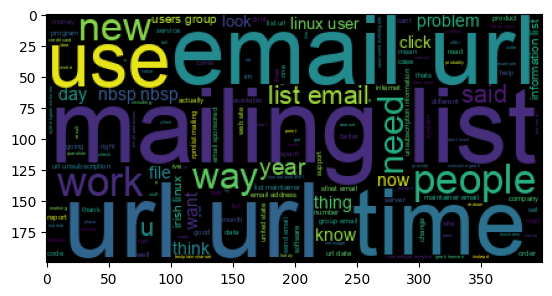

In [57]:
plt.imshow(img)